## 1. Импорт необходимых библиотек

#### Основные библиотеки

In [71]:
import sys
import numpy as np                # Для работы с массивами
import matplotlib.pyplot as plt
import random
print('NumPy: ',np.__version__)

NumPy:  1.19.2


#### Библиотеки для работы с файлами SEGY

In [72]:
from obspy import read, Trace, Stream, UTCDateTime
from obspy.core import AttribDict
from obspy.io.segy.segy import SEGYTraceHeader, SEGYBinaryFileHeader
from obspy.io.segy.core import _read_segy

#### Библиотеки для реализации преобразования Фурье

In [73]:
from numpy.fft import fft, rfft, rfftfreq     

#### Библиотека для создания помех сигнала (шума)

In [74]:
from numpy.random import uniform 

## 2. Создание функций

#### Функция для расчёта зависимости вида:

$$y(t)=A exp\big(-\big[\frac {t-t_0} {\tau} \big]^2\big)$$

In [75]:
A=50                                                #Амплитуда сигнала
t_start=0                                           #Первый элемент массива времени
t_finish=1                                          #Последний элемент массива времени
t_step=0.002                                        #Шаг по времени с которым производятся вычисления
tmas=np.arange(t_start,t_finish+t_step,t_step)      #Массив времени заданным шагом
N=len(tmas)                                         #Кол-во отсчётов
f=50

def make_signal():
    data = A*np.cos(2*np.pi*f*tmas)           
    freq_sig=f
    return data, freq_sig

#### Функция создания шума

In [76]:
a=50                                                 #Амплитуда шума

def make_noise(proc_freq_noise):
    f_noise=round(f*proc_freq_noise/100,2)
    period=round(1/f_noise,2)
    noise = np.zeros(N)
    num=period/t_step
    
    i=0
    while i<N:
        if i==num:
            noise[i]=random.randint(-a, a)
            num+=round(period/t_step,2)
        else:
            noise[i]=noise[i-1]
        i+=1
    return noise,f_noise
    

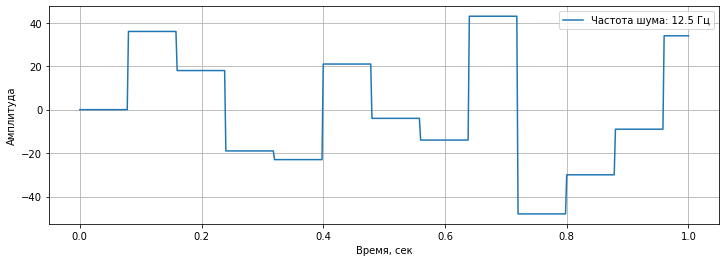

In [77]:
noise_t, f_noise_t = make_noise(25)
plt.figure(figsize=(12, 4))
plt.plot(tmas, noise_t, label = "Частота шума: {} Гц".format(f_noise_t))
plt.ylabel('Амплитуда')
plt.xlabel('Время, сек')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
a=50                                                 #Амплитуда шума

def make_noise2(proc_freq_noise):
    f_noise=round(f*proc_freq_noise/100,2)
    period=round(1/f_noise,2)
    noise = np.zeros(N)
    num=period/t_step
    i=0
    while i<N:
        if i==num:
            noise[i]=random.randint(-a, a)
            num+=round(period/t_step,2)
        i+=1
    return noise,f_noise

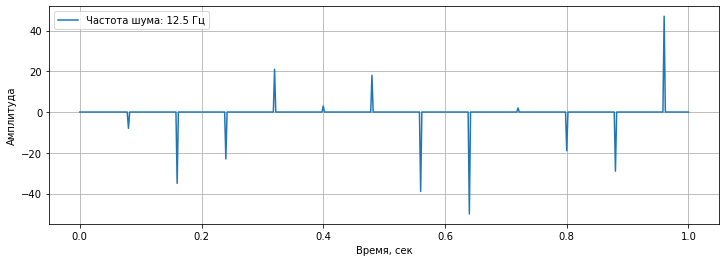

In [79]:
noise_tt, f_noise_tt = make_noise2(25)
plt.figure(figsize=(12, 4))
plt.plot(tmas, noise_tt, label = "Частота шума: {} Гц".format(f_noise_tt))
plt.legend()
plt.ylabel('Амплитуда')
plt.xlabel('Время, сек')
plt.grid(True)
plt.show()

In [80]:
a=50                                                 #Амплитуда шума

def make_noise(proc_freq_noise, freq_sig):
    k=0
    noise = np.zeros(N)
    dol=100/proc_freq_noise
    while k<len(noise):
        if k%dol == 0:
            noise[k]=random.randint(-a, a)
        else:
            noise[k]=noise[k-1]
        k+=1
    freq_noise=freq_sig*proc_freq_noise/100
    return noise, freq_noise

#### Функция создания "потока"

In [81]:
num_trace=10                                        #Количество трасс в одном потоке

def make_segy(n,proc_freq_noise):
    for _i in range(num_trace):     # Цикл вызывается каждый раз при создании новой трассы
        data, freq_sig = make_signal()
        if n==True:
            noise, freq_noise = make_noise(proc_freq_noise,freq_sig)
            data = data + noise
        data = np.require(data, dtype=np.float32)
        trace = Trace(data=data)
        trace.stats.delta = t_step                 ## Атрибут trace.stats будет переписывать все в trace.stats.segy.trace_header. SEGY не поддерживает точность сотых долей секунды, они будут отброшены

        if not hasattr(trace.stats, 'segy.trace_header'):     ## Возвращает флаг, указывающий на то, содержит ли объект указанный атрибут hasattr(obj, name) -> bool
             trace.stats.segy = {}                            ## Словарь/набор
        trace.stats.segy.trace_header = SEGYTraceHeader()
        trace.stats.segy.trace_header.trace_sequence_number_within_line = _i + 1
        
        stream.append(trace)                             # Добавить трассу в stream
    
    stream.stats = AttribDict()
    stream.stats.textual_file_header = 'Textual Header!'
    stream.stats.binary_file_header = SEGYBinaryFileHeader()
    #print ("Объект stream перед записью...", '\n', stream)
    if n==True:
        return stream, tmas, freq_sig, freq_noise
    else:
        return stream, tmas, freq_sig

#### Функция для записи потока в SEGY

In [82]:
def write_segy(name,st):   
    st.write(name, format="SEGY", data_encoding=1, byteorder=sys.byteorder)

#### Функция получения данных из файла

In [83]:
def data_segy(name_file):
    STREAM = _read_segy(name_file)
    DATA = np.stack(t.data for t in STREAM.traces)
    print('Количество трасс: ', DATA.shape[0], '\n',
         'Количество элементов в каждой трассе: ', DATA.shape[1], sep='')
    return STREAM, DATA

#### Функция создания графика одной трассы

In [84]:
def print_one_trace(num,STREAM,NE):
    y=STREAM.traces[num]
    plt.figure(figsize=(12, 4))
    plt.plot(tmas, y)
    plt.grid(True)
    plt.ylabel('Амплитуда')
    plt.xlabel('Время, сек')
    if NE==True:
        plt.title("Частота сигнала: {:.0f} Гц; Частота шума: {:.0f} Гц".format(freq_sig, freq_noise))
    else:
        plt.title("Частота сигнала: {:.0f} Гц".format(freq_sig_no_noise))
    plt.show()
    return y

#### Функция построения амплитудных спектров

In [85]:
def make_AS(trace_num, name):
    spectrum = rfft(trace_num)
    X=rfftfreq(len(tmas), t_step)
    Y=np.abs(spectrum)/len(spectrum)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(X,Y)
    ax.grid(True)
    ax.set_ylabel('"Мощность"')
    ax.set_xlabel('Частота, Hz')
    plt.title(name)
    plt.show()

#### Построение графика с шагом по времени и точками по количеству отсчётов

In [86]:
def change_DT(dt):
    Tmas=np.arange(t_start,t_finish+dt,dt)
    Data = A*np.cos(2*np.pi*f*Tmas) 

    spectrum_test = rfft(Data)
    X_test=rfftfreq(len(Tmas), dt)
    Y_test=np.abs(spectrum_test)/len(spectrum_test)

    print("Время между точками {} сек; частота дискретизации {:.0f} Гц".format(dt, 1/dt))
    
    fig, ax = plt.subplots()
    ax.plot(Tmas, Data, label = dt)
    ax.plot(Tmas, Data, 'ro')
    ax.grid(True)
    ax.set_ylabel('Амплитуда')
    ax.set_xlabel('Время, с')
    plt.legend()
    #plt.title('Амплитудный спектр')
    plt.show()
    
    print("Количество точек на первом графике {}; Количество точек на втором графике {:.0f}".format(len(Data), len(Y_test)))
    
    fig, ax = plt.subplots()
    ax.plot(X_test,Y_test, label = dt)
    ax.plot(X_test,Y_test, 'ro')
    ax.grid(True)
    ax.set_ylabel('Амплитуда')
    ax.set_xlabel('Частота, Hz')
    plt.title('Амплитудный спектр')
    plt.legend()
    plt.show()

#### Функция построения графиков с различными значениями времени между снятиями отсчётов

In [87]:
def change_dt(mas_dt):
    mas_Tmas=[[],[],[]]
    mas_data=[[],[],[]]
    X=[[],[],[]]
    Y=[[],[],[]]
    i=0
    while i<len(mas_dt):
        Tmas=np.arange(t_start,t_finish+mas_dt[i],mas_dt[i])
        mas_Tmas[i]=Tmas
        Data = Data = A*np.cos(2*np.pi*f*Tmas)
        mas_data[i]=Data

        spectrum_test = rfft(Data)
        X_test=rfftfreq(len(Tmas), mas_dt[i])
        X[i]=X_test
        Y_test=np.abs(spectrum_test)/len(spectrum_test)
        Y[i]=Y_test
        i+=1
        
    fig, ax = plt.subplots()
    ax.plot(mas_Tmas[0], mas_data[0], label = mas_dt[0])
    ax.plot(mas_Tmas[1], mas_data[1], label = mas_dt[1])
    ax.plot(mas_Tmas[2], mas_data[2], label = mas_dt[2])
    ax.grid(True)
    ax.set_ylabel('Амплитуда')
    ax.set_xlabel('Время, с')
    plt.legend()
    #plt.title('Амплитудный спектр')
    ax.set_xlim(0.4, 0.6)
    plt.show()
        
    fig, ax = plt.subplots()
    ax.plot(X[0],Y[0], label = mas_dt[0])
    ax.plot(X[1],Y[1], label = mas_dt[1])
    ax.plot(X[2],Y[2], label = mas_dt[2])
    
    ax.grid(True)
    ax.set_ylabel('Амплитуда')
    ax.set_xlabel('Частота, Hz')
    plt.title('Амплитудный спектр')
    plt.legend()
    ax.set_xlim(-5, 50)
    plt.show()

## 3. Начало расчётов

### 3.1 Создание SEGY файлов с шумом и без

Создаём поток (без шума)

In [88]:
stream = Stream()
stream_no_noise, tmas, freq_sig_no_noise = make_segy(n=False,proc_freq_noise=25)

Записываем получившийся поток (без шума) в файл формата .sgy

In [89]:
write_segy("sig_no_noise.sgy",stream_no_noise)

Создаём поток (без шума)

In [90]:
stream = Stream()
stream_noise, tmas, freq_sig, freq_noise = make_segy(n=True, proc_freq_noise=25)

Записываем получившийся поток (c шумом) в файл формата .sgy

In [91]:
write_segy("sig_noise.sgy",stream_noise)

### 3.2 Визуализация одной сгенерированной трассы с шумом и без

In [92]:
STREAM_no_noise, DATA_no_noise = data_segy("sig_no_noise.sgy")

Количество трасс: 10
Количество элементов в каждой трассе: 501


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [93]:
STREAM_noise, DATA_noise = data_segy("sig_noise.sgy")

Количество трасс: 10
Количество элементов в каждой трассе: 501


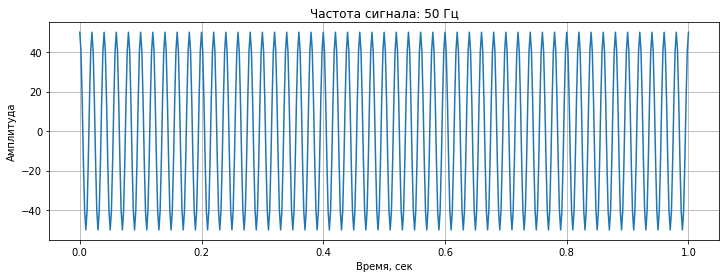

In [94]:
trace5_no_noise=print_one_trace(5,STREAM_no_noise,False)

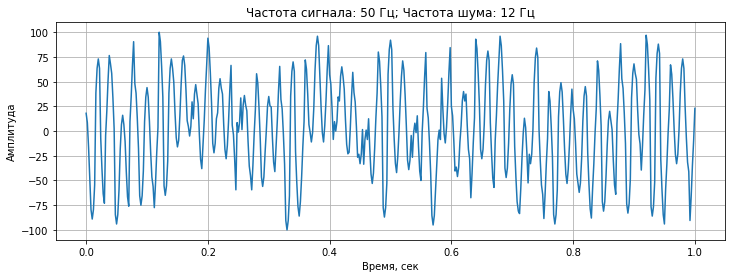

In [95]:
trace5_noise=print_one_trace(5,STREAM_noise,True)

### 3.2 Амплитудный спектр сигнала с шумом и без

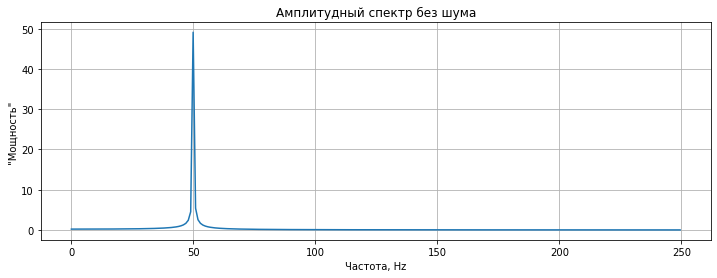

In [96]:
make_AS(trace5_no_noise, "Амплитудный спектр без шума")

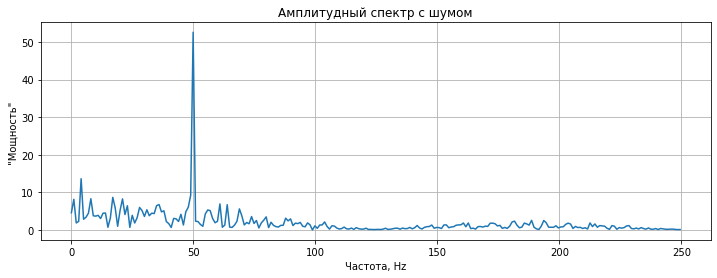

In [97]:
make_AS(trace5_noise, "Амплитудный спектр c шумом")

### 3.4 Проверка как влияет частота дискретизации на амплитудный спектр

Время между точками 0.002 сек; частота дискретизации 500 Гц


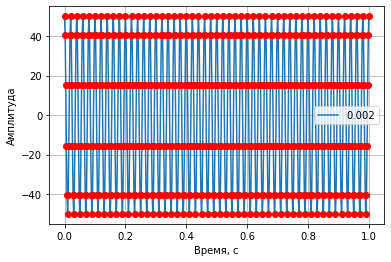

Количество точек на первом графике 501; Количество точек на втором графике 251


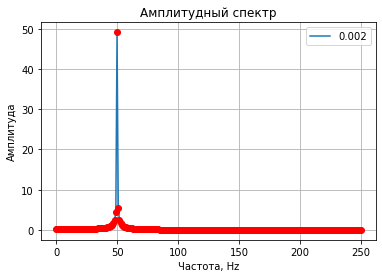

In [98]:
change_DT(0.002)

Время между точками 0.01 сек; частота дискретизации 100 Гц


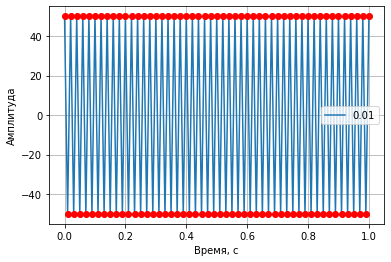

Количество точек на первом графике 101; Количество точек на втором графике 51


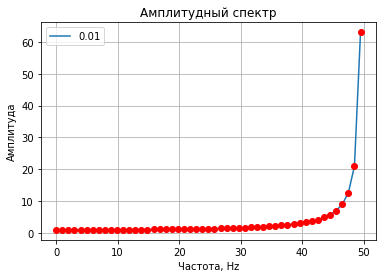

In [101]:
change_DT(0.01)